# Convert conservative to potential temp

WOA has been converted to consv temp

But Wright EOS expects potential temp

Use gsw tools to convert

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean as cm
import warnings
warnings.filterwarnings("ignore")
import xgcm

import os
from pathlib import Path
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42045,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:36145,Total threads: 4
Dashboard: /proxy/32877/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:43877,


# load file

In [5]:
IC_consv = xr.open_mfdataset('/g/data/x77/cy8964/mom6/input/input-8km/WOA_IC_bfilled_smoothedland.nc', parallel = True,
                            chunks={'nyp':100,'nxp':400})

In [6]:
IC_consv


<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nyp: 1442, nxp: 4320)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
Data variables:
    temp     (depth, nyp, nxp) float64 4GB dask.array<chunksize=(75, 100, 400), meta=np.ndarray>
    salt     (depth, nyp, nxp) float64 4GB dask.array<chunksize=(75, 100, 400), meta=np.ndarray>

In [7]:
IC_consv = IC_consv.load()

# Check info about original file (before regridding)

In [4]:
!ncdump -h /g/data/ik11/inputs/access-om2/input_20201022/mom_01deg/ocean_temp_salt.res.nc

netcdf ocean_temp_salt.res {
dimensions:
	GRID_X_T = 3600 ;
	GRID_Y_T = 2700 ;
	ZT = 75 ;
	time = UNLIMITED ; // (1 currently)
variables:
	double GRID_X_T(GRID_X_T) ;
		GRID_X_T:long_name = "Nominal Longitude of T-cell center" ;
		GRID_X_T:units = "degree_east" ;
		GRID_X_T:modulo = 360. ;
		GRID_X_T:point_spacing = "even" ;
		GRID_X_T:axis = "X" ;
	double GRID_Y_T(GRID_Y_T) ;
		GRID_Y_T:long_name = "Nominal Latitude of T-cell center" ;
		GRID_Y_T:units = "degree_north" ;
		GRID_Y_T:point_spacing = "uneven" ;
		GRID_Y_T:axis = "Y" ;
	double ZT(ZT) ;
		ZT:long_name = "zt" ;
		ZT:units = "meters" ;
		ZT:positive = "down" ;
		ZT:point_spacing = "uneven" ;
		ZT:axis = "Z" ;
	double time(time) ;
		time:long_name = "time" ;
		time:units = "days since 0001-01-01 00:00:00" ;
		time:cartesian_axis = "T" ;
		time:calendar_type = "GREGORIAN" ;
		time:calendar = "GREGORIAN" ;
	double temp(time, ZT, GRID_Y_T, GRID_X_T) ;
		temp:_FillValue = -1.e+34 ;
		temp:missing_value = -1.e+34 ;
		temp:long_nam

https://github.com/COSIMA/initial_conditions_access-om2/blob/f24b8f27872f52bcbc80d24ddf727feeeb85738d/setup_WOA_initial_conditions.py suggests practical salinity. Absolute salinity needed for gsw pt from CT. Luckily, above script also does that.

In [8]:
import gsw

In [9]:
depths = xr.zeros_like(IC_consv.salt)+IC_consv.depth
lats = xr.zeros_like(IC_consv.salt)+IC_consv.nyp
lons = xr.zeros_like(IC_consv.salt)+IC_consv.nxp
pressure = gsw.p_from_z(-depths,lats)

In [10]:
pressure

<xarray.DataArray (depth: 75, nyp: 1442, nxp: 4320)> Size: 4GB
array([[[5.47145667e-01, 5.47145667e-01, 5.47145667e-01, ...,
         5.47145667e-01, 5.47145667e-01, 5.47145667e-01],
        [5.47145533e-01, 5.47145533e-01, 5.47145533e-01, ...,
         5.47145533e-01, 5.47145533e-01, 5.47145533e-01],
        [5.47145399e-01, 5.47145399e-01, 5.47145399e-01, ...,
         5.47145399e-01, 5.47145399e-01, 5.47145399e-01],
        ...,
        [5.45343369e-01, 5.45343369e-01, 5.45343369e-01, ...,
         5.45343369e-01, 5.45343369e-01, 5.45343369e-01],
        [5.45340158e-01, 5.45340158e-01, 5.45340158e-01, ...,
         5.45340158e-01, 5.45340158e-01, 5.45340158e-01],
        [5.45336945e-01, 5.45336945e-01, 5.45336945e-01, ...,
         5.45336945e-01, 5.45336945e-01, 5.45336945e-01]],

       [[1.69895058e+00, 1.69895058e+00, 1.69895058e+00, ...,
         1.69895058e+00, 1.69895058e+00, 1.69895058e+00],
        [1.69895016e+00, 1.69895016e+00, 1.69895016e+00, ...,
         1.69895016e+00, 1.69895016e+00, 1.69895016e+00],
        [1.69894975e+00, 1.69894975e+00, 1.69894975e+00, ...,
         1.69894975e+00, 1.69894975e+00, 1.69894975e+00],
...
        [5.62510963e+03, 5.62510963e+03, 5.62510963e+03, ...,
         5.62510963e+03, 5.62510963e+03, 5.62510963e+03],
        [5.62507610e+03, 5.62507610e+03, 5.62507610e+03, ...,
         5.62507610e+03, 5.62507610e+03, 5.62507610e+03],
        [5.62504257e+03, 5.62504257e+03, 5.62504257e+03, ...,
         5.62504257e+03, 5.62504257e+03, 5.62504257e+03]],

       [[5.84959374e+03, 5.84959374e+03, 5.84959374e+03, ...,
         5.84959374e+03, 5.84959374e+03, 5.84959374e+03],
        [5.84959230e+03, 5.84959230e+03, 5.84959230e+03, ...,
         5.84959230e+03, 5.84959230e+03, 5.84959230e+03],
        [5.84959084e+03, 5.84959084e+03, 5.84959084e+03, ...,
         5.84959084e+03, 5.84959084e+03, 5.84959084e+03],
        ...,
        [5.83008920e+03, 5.83008920e+03, 5.83008920e+03, ...,
         5.83008920e+03, 5.83008920e+03, 5.83008920e+03],
        [5.83005445e+03, 5.83005445e+03, 5.83005445e+03, ...,
         5.83005445e+03, 5.83005445e+03, 5.83005445e+03],
        [5.83001968e+03, 5.83001968e+03, 5.83001968e+03, ...,
         5.83001968e+03, 5.83001968e+03, 5.83001968e+03]]])
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96

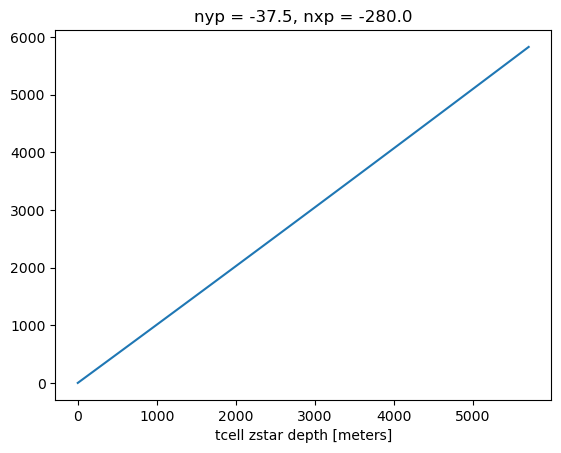

In [11]:
pressure.isel(nyp = -1,nxp = 0).plot()

In [23]:
lats

<xarray.DataArray (depth: 75, nyp: 1442, nxp: 4320)> Size: 4GB
array([[[-86.48922075, -86.48922075, -86.48922075, ..., -86.48922075,
         -86.48922075, -86.48922075],
        [-86.46766225, -86.46766225, -86.46766225, ..., -86.46766225,
         -86.46766225, -86.46766225],
        [-86.44610375, -86.44610375, -86.44610375, ..., -86.44610375,
         -86.44610375, -86.44610375],
        ...,
        [-37.6278966 , -37.6278966 , -37.6278966 , ..., -37.6278966 ,
         -37.6278966 , -37.6278966 ],
        [-37.56186793, -37.56186793, -37.56186793, ..., -37.56186793,
         -37.56186793, -37.56186793],
        [-37.49578069, -37.49578069, -37.49578069, ..., -37.49578069,
         -37.49578069, -37.49578069]],

       [[-86.48922075, -86.48922075, -86.48922075, ..., -86.48922075,
         -86.48922075, -86.48922075],
        [-86.46766225, -86.46766225, -86.46766225, ..., -86.46766225,
         -86.46766225, -86.46766225],
        [-86.44610375, -86.44610375, -86.44610375, ..., -86.44610375,
         -86.44610375, -86.44610375],
...
        [-37.6278966 , -37.6278966 , -37.6278966 , ..., -37.6278966 ,
         -37.6278966 , -37.6278966 ],
        [-37.56186793, -37.56186793, -37.56186793, ..., -37.56186793,
         -37.56186793, -37.56186793],
        [-37.49578069, -37.49578069, -37.49578069, ..., -37.49578069,
         -37.49578069, -37.49578069]],

       [[-86.48922075, -86.48922075, -86.48922075, ..., -86.48922075,
         -86.48922075, -86.48922075],
        [-86.46766225, -86.46766225, -86.46766225, ..., -86.46766225,
         -86.46766225, -86.46766225],
        [-86.44610375, -86.44610375, -86.44610375, ..., -86.44610375,
         -86.44610375, -86.44610375],
        ...,
        [-37.6278966 , -37.6278966 , -37.6278966 , ..., -37.6278966 ,
         -37.6278966 , -37.6278966 ],
        [-37.56186793, -37.56186793, -37.56186793, ..., -37.56186793,
         -37.56186793, -37.56186793],
        [-37.49578069, -37.49578069, -37.49578069, ..., -37.49578069,
         -37.49578069, -37.49578069]]])
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96

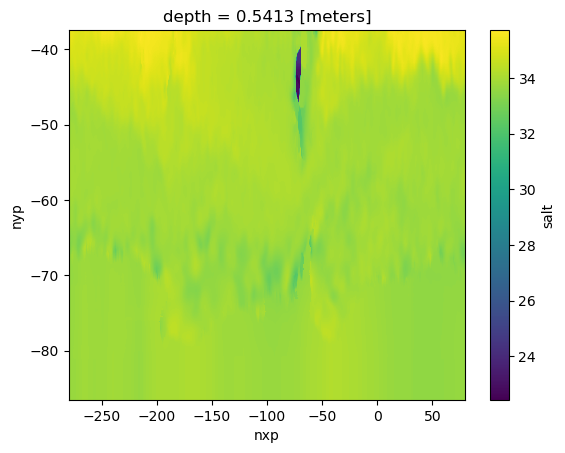

In [24]:
IC_consv.salt.isel(depth = 0).plot()

In [35]:
s_absolute = gsw.SA_from_SP(IC_consv.salt,pressure,
    		lons,lats).bfill('nyp')

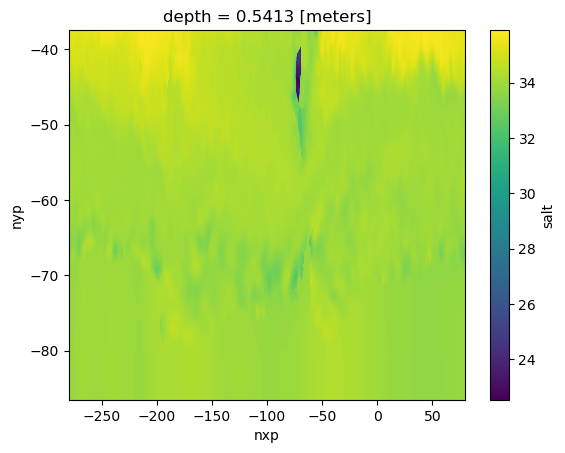

In [36]:
s_absolute.isel(depth = 0).plot()

In [37]:
s_absolute

<xarray.DataArray 'salt' (depth: 75, nyp: 1442, nxp: 4320)> Size: 4GB
array([[[33.78729255, 33.7888293 , 33.79034142, ..., 33.78454643,
         33.78582639, 33.78710594],
        [33.78729255, 33.7888293 , 33.79034142, ..., 33.78454643,
         33.78582639, 33.78710594],
        [33.78729255, 33.7888293 , 33.79034142, ..., 33.78454643,
         33.78582639, 33.78710594],
        ...,
        [35.40968309, 35.41168555, 35.41439224, ..., 35.40560444,
         35.40639293, 35.4079159 ],
        [35.40953608, 35.41103033, 35.41321307, ..., 35.40691942,
         35.40724244, 35.40827183],
        [35.40938891, 35.41037442, 35.41203264, ..., 35.40823579,
         35.40809285, 35.40862814]],

       [[33.80667735, 33.80822959, 33.80976118, ..., 33.80390869,
         33.80519484, 33.80648057],
        [33.80667735, 33.80822959, 33.80976118, ..., 33.80390869,
         33.80519484, 33.80648057],
        [33.80667735, 33.80822959, 33.80976118, ..., 33.80390869,
         33.80519484, 33.80648057],
...
        [34.90783204, 34.90783047, 34.90782889, ..., 34.90786557,
         34.90785248, 34.90783938],
        [34.90783696, 34.9078353 , 34.90783365, ..., 34.90787028,
         34.90785728, 34.90784428],
        [34.90784187, 34.90784014, 34.90783841, ..., 34.90787499,
         34.90786209, 34.90784919]],

       [[34.84828664, 34.84843849, 34.84849258, ..., 34.84827023,
         34.84832497, 34.84837919],
        [34.84828664, 34.84843849, 34.84849258, ..., 34.84827023,
         34.84832497, 34.84837919],
        [34.84828664, 34.84843849, 34.84849258, ..., 34.84827023,
         34.84832497, 34.84837919],
        ...,
        [34.90783204, 34.90783047, 34.90782889, ..., 34.90786557,
         34.90785248, 34.90783938],
        [34.90783696, 34.9078353 , 34.90783365, ..., 34.90787028,
         34.90785728, 34.90784428],
        [34.90784187, 34.90784014, 34.90783841, ..., 34.90787499,
         34.90786209, 34.90784919]]])
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96

In [45]:
t_potential = gsw.pt_from_CT(s_absolute,IC_consv.temp)


In [46]:
t_potential = t_potential.load()

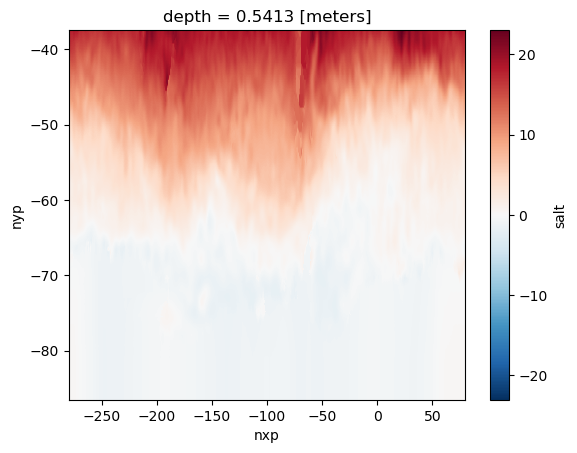

In [47]:
t_potential.isel(depth = 0).plot()

#### Check difference consv -  potential temp

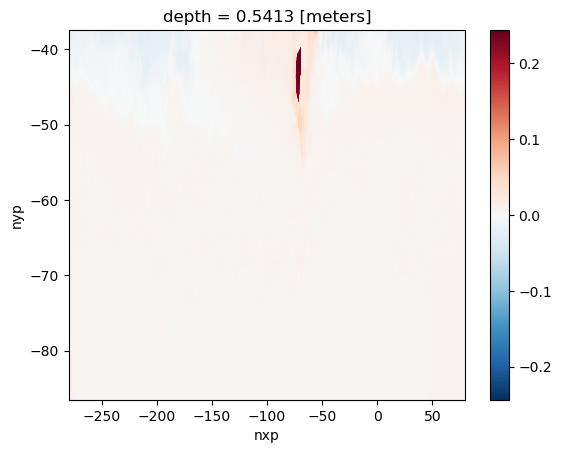

In [48]:
(IC_consv.temp.isel(depth = 0)-t_potential.isel(depth = 0)).plot()

In [49]:
IC_pot = IC_consv.copy()
IC_pot["temp"] = t_potential#.values


In [50]:
#add metadata
IC_pot.temp.attrs = {'long_name':'potential temperature', 'description':'Pot temp converted from conservative temp in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/main/initial-conditions/convert-CT-pt.ipynb, remapping in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/main/initial-conditions/WOA_IC_into_8km_grid.ipynb, originally from WOA in situ temp https://github.com/COSIMA/initial_conditions_access-om2/blob/f24b8f27872f52bcbc80d24ddf727feeeb85738d/setup_WOA_initial_conditions.py'}
IC_pot.salt.attrs = {'long_name':'practical salinity', 'description':'Remapping in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/main/initial-conditions/WOA_IC_into_8km_grid.ipynb, originally from WOA in situ temp https://github.com/COSIMA/initial_conditions_access-om2/blob/f24b8f27872f52bcbc80d24ddf727feeeb85738d/setup_WOA_initial_conditions.py'}

                     

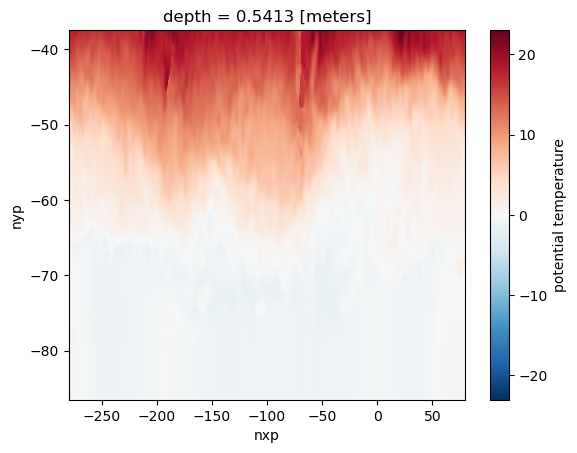

In [51]:
IC_pot.temp.isel(depth = 0).plot()

In [52]:
IC_pot.temp

<xarray.DataArray 'temp' (depth: 75, nyp: 1442, nxp: 4320)> Size: 4GB
array([[[ 0.33966209,  0.34002   ,  0.34048122, ...,  0.34392845,
          0.3440282 ,  0.34412775],
        [ 0.33966209,  0.34002   ,  0.34048122, ...,  0.34392845,
          0.3440282 ,  0.34412775],
        [ 0.33966209,  0.34002   ,  0.34048122, ...,  0.34392845,
          0.3440282 ,  0.34412775],
        ...,
        [18.16639773, 18.13675592, 18.11058191, ..., 18.25862827,
         18.22783221, 18.19713108],
        [18.25644817, 18.22703213, 18.20148194, ..., 18.34824296,
         18.31766534, 18.28708851],
        [18.34659308, 18.31740293, 18.29247707, ..., 18.43795199,
         18.40759294, 18.37714044]],

       [[ 0.31659637,  0.316997  ,  0.31750518, ...,  0.32075319,
          0.32088608,  0.32101881],
        [ 0.31659637,  0.316997  ,  0.31750518, ...,  0.32075319,
          0.32088608,  0.32101881],
        [ 0.31659637,  0.316997  ,  0.31750518, ...,  0.32075319,
          0.32088608,  0.32101881],
...
        [ 0.04188909,  0.04531055,  0.04683456, ...,  0.03479033,
          0.03479027,  0.03783261],
        [ 0.04188912,  0.04822274,  0.06139536, ...,  0.03479035,
          0.03479029,  0.03783263],
        [ 0.04188914,  0.05113802,  0.07597163, ...,  0.03479037,
          0.03479031,  0.03783265]],

       [[-1.95994887, -1.95983567, -1.95971699, ..., -1.96014195,
         -1.96002327, -1.95990459],
        [-1.95994887, -1.95983567, -1.95971699, ..., -1.96014195,
         -1.96002327, -1.95990459],
        [-1.95994887, -1.95983567, -1.95971699, ..., -1.96014195,
         -1.96002327, -1.95990459],
        ...,
        [ 0.04188909,  0.04531055,  0.04683456, ...,  0.03479033,
          0.03479027,  0.03783261],
        [ 0.04188912,  0.04822274,  0.06139536, ...,  0.03479035,
          0.03479029,  0.03783263],
        [ 0.04188914,  0.05113802,  0.07597163, ...,  0.03479037,
          0.03479031,  0.03783265]]])
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
Attributes:
    long_name:    potential temperature
    description:  Pot temp converted from conservative temp in https://github...

In [64]:
#save to netcdf
enc_TS = {
    "_FillValue": -1.e-20,
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}
IC_pot.to_netcdf('/g/data/x77/cy8964/mom6/input/input-8km/WOA_IC_bfilled_smoothedland_pottemp.nc', encoding={"temp": enc_TS, "salt": enc_TS})


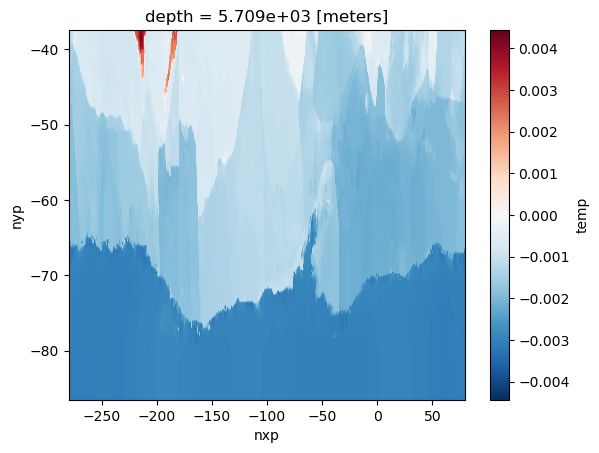

In [60]:
(IC_pot.temp-IC_consv.temp).isel(depth = -1).plot()

In [65]:
IC_pot.temp.max().values

array(23.03446714)

In [66]:
IC_pot.temp.min().values

array(-2.12991634)

In [67]:
IC_consv.temp.max().values

array(23.01474883)

In [68]:
IC_consv.temp.min().values

array(-2.12677646)

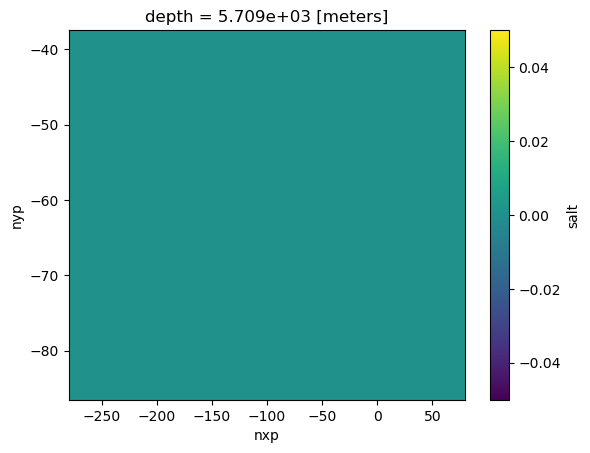

In [63]:
(IC_pot.salt-IC_consv.salt).isel(depth = -1).plot()

In [61]:
IC_pot

<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nyp: 1442, nxp: 4320)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
Data variables:
    temp     (depth, nyp, nxp) float64 4GB 0.3397 0.34 ... 0.03479 0.03783
    salt     (depth, nyp, nxp) float64 4GB 33.63 33.63 33.63 ... 34.74 34.74

In [62]:
IC_consv

<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nyp: 1442, nxp: 4320)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
Data variables:
    temp     (depth, nyp, nxp) float64 4GB 0.3457 0.3461 ... 0.03588 0.03892
    salt     (depth, nyp, nxp) float64 4GB 33.63 33.63 33.63 ... 34.74 34.74